## 目的：利用不同方法实现跨频耦合值的计算
### 各个方法的更多介绍参考：https://weisihong9.github.io/2023/07/05/CrossFrequencyCoupling/

### 0 加载python库

In [1]:
import os
import mne
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy.signal import hilbert
import scipy.io
from scipy import signal

### 1 定义耦合函数

#### 1.1 PLV

In [2]:
def PLV_CFC_WSH(phase, amp):
    # 利用PLV计算相幅耦合
    # phase：低频信号的相位
    # amp：高频信号的振幅
    amp_phi = np.angle(hilbert(amp))        # 高频信号振幅的相位
    observed_plv = np.abs(np.sum(np.exp(1j*(phase - amp_phi)))/len(phase))
    return observed_plv

#### 1.2 MVL

In [3]:
def MVL_CFC_WSH(phase, amp):
    # 利用MVL计算相幅耦合
    # phase：低频信号的相位
    # amp：高频信号的振幅
    amp_nor = (amp - np.min(amp)) / (np.max(amp) - np.min(amp))  # 振幅归一化
    observed_mvl = np.abs(np.mean(amp_nor * np.exp(1j*phase)))
    return observed_mvl

#### 1.3 MI

In [4]:
# 利用MI计算相幅耦合
def MI_CFC_WSH(phase, amp, nbins):
    # phase：低频信号的相位
    # amp：高频信号的振幅
    # nbins：划分的箱子数
    bins = np.linspace(-np.pi, np.pi, nbins+1)   
    # 计算每个相位区间内的振幅均值 
    meanAmp = np.zeros(nbins)
    for i in range(nbins):
        indices = np.logical_and(phase >= bins[i], phase < bins[i+1])
        meanAmp[i] = np.mean(amp[indices])
    Pj = meanAmp/np.sum(meanAmp)
    H_Pj = -np.sum((Pj) * np.log(Pj))
    KL = np.log(nbins) - H_Pj
    observed_mi = KL / np.log(nbins)
    return [observed_mi, meanAmp]

### 2 定义滤波函数

In [5]:
def filterFGx(data, srate, f, fwhm, showplot=False):
    # data: （xxxx, ）
    # Input check
    if data.shape[0] > len(data):
        raise ValueError('Check data size')
    if (f - fwhm) < 0:
        raise ValueError('Increase frequency or decrease FWHM')
    if fwhm <= 0:
        raise ValueError('FWHM must be greater than 0')
    
    # Compute and apply filter
    hz = np.linspace(0, srate, len(data)) # 对的
    s = fwhm * (2 * np.pi - 1) / (4 * np.pi)  # Normalized width # 对的
    x = hz - f  # Shifted frequencies # 对的
    fx = np.exp(-0.5 * (x / s) ** 2)  # Gaussian # 对的
    fx = fx / np.abs(np.max(fx))  # Gain-normalized  # 对的
    # fft 和 ifft
    fft_data = np.fft.fft(data)                         # 功率谱，power
    filtered_data = (np.fft.ifft(fft_data * fx)).T      # 逆变换
    filtdat = 2 * np.real(filtered_data)
    
    return filtdat

## 一、计算模拟信号耦合值

### 3. 生成耦合示例信号

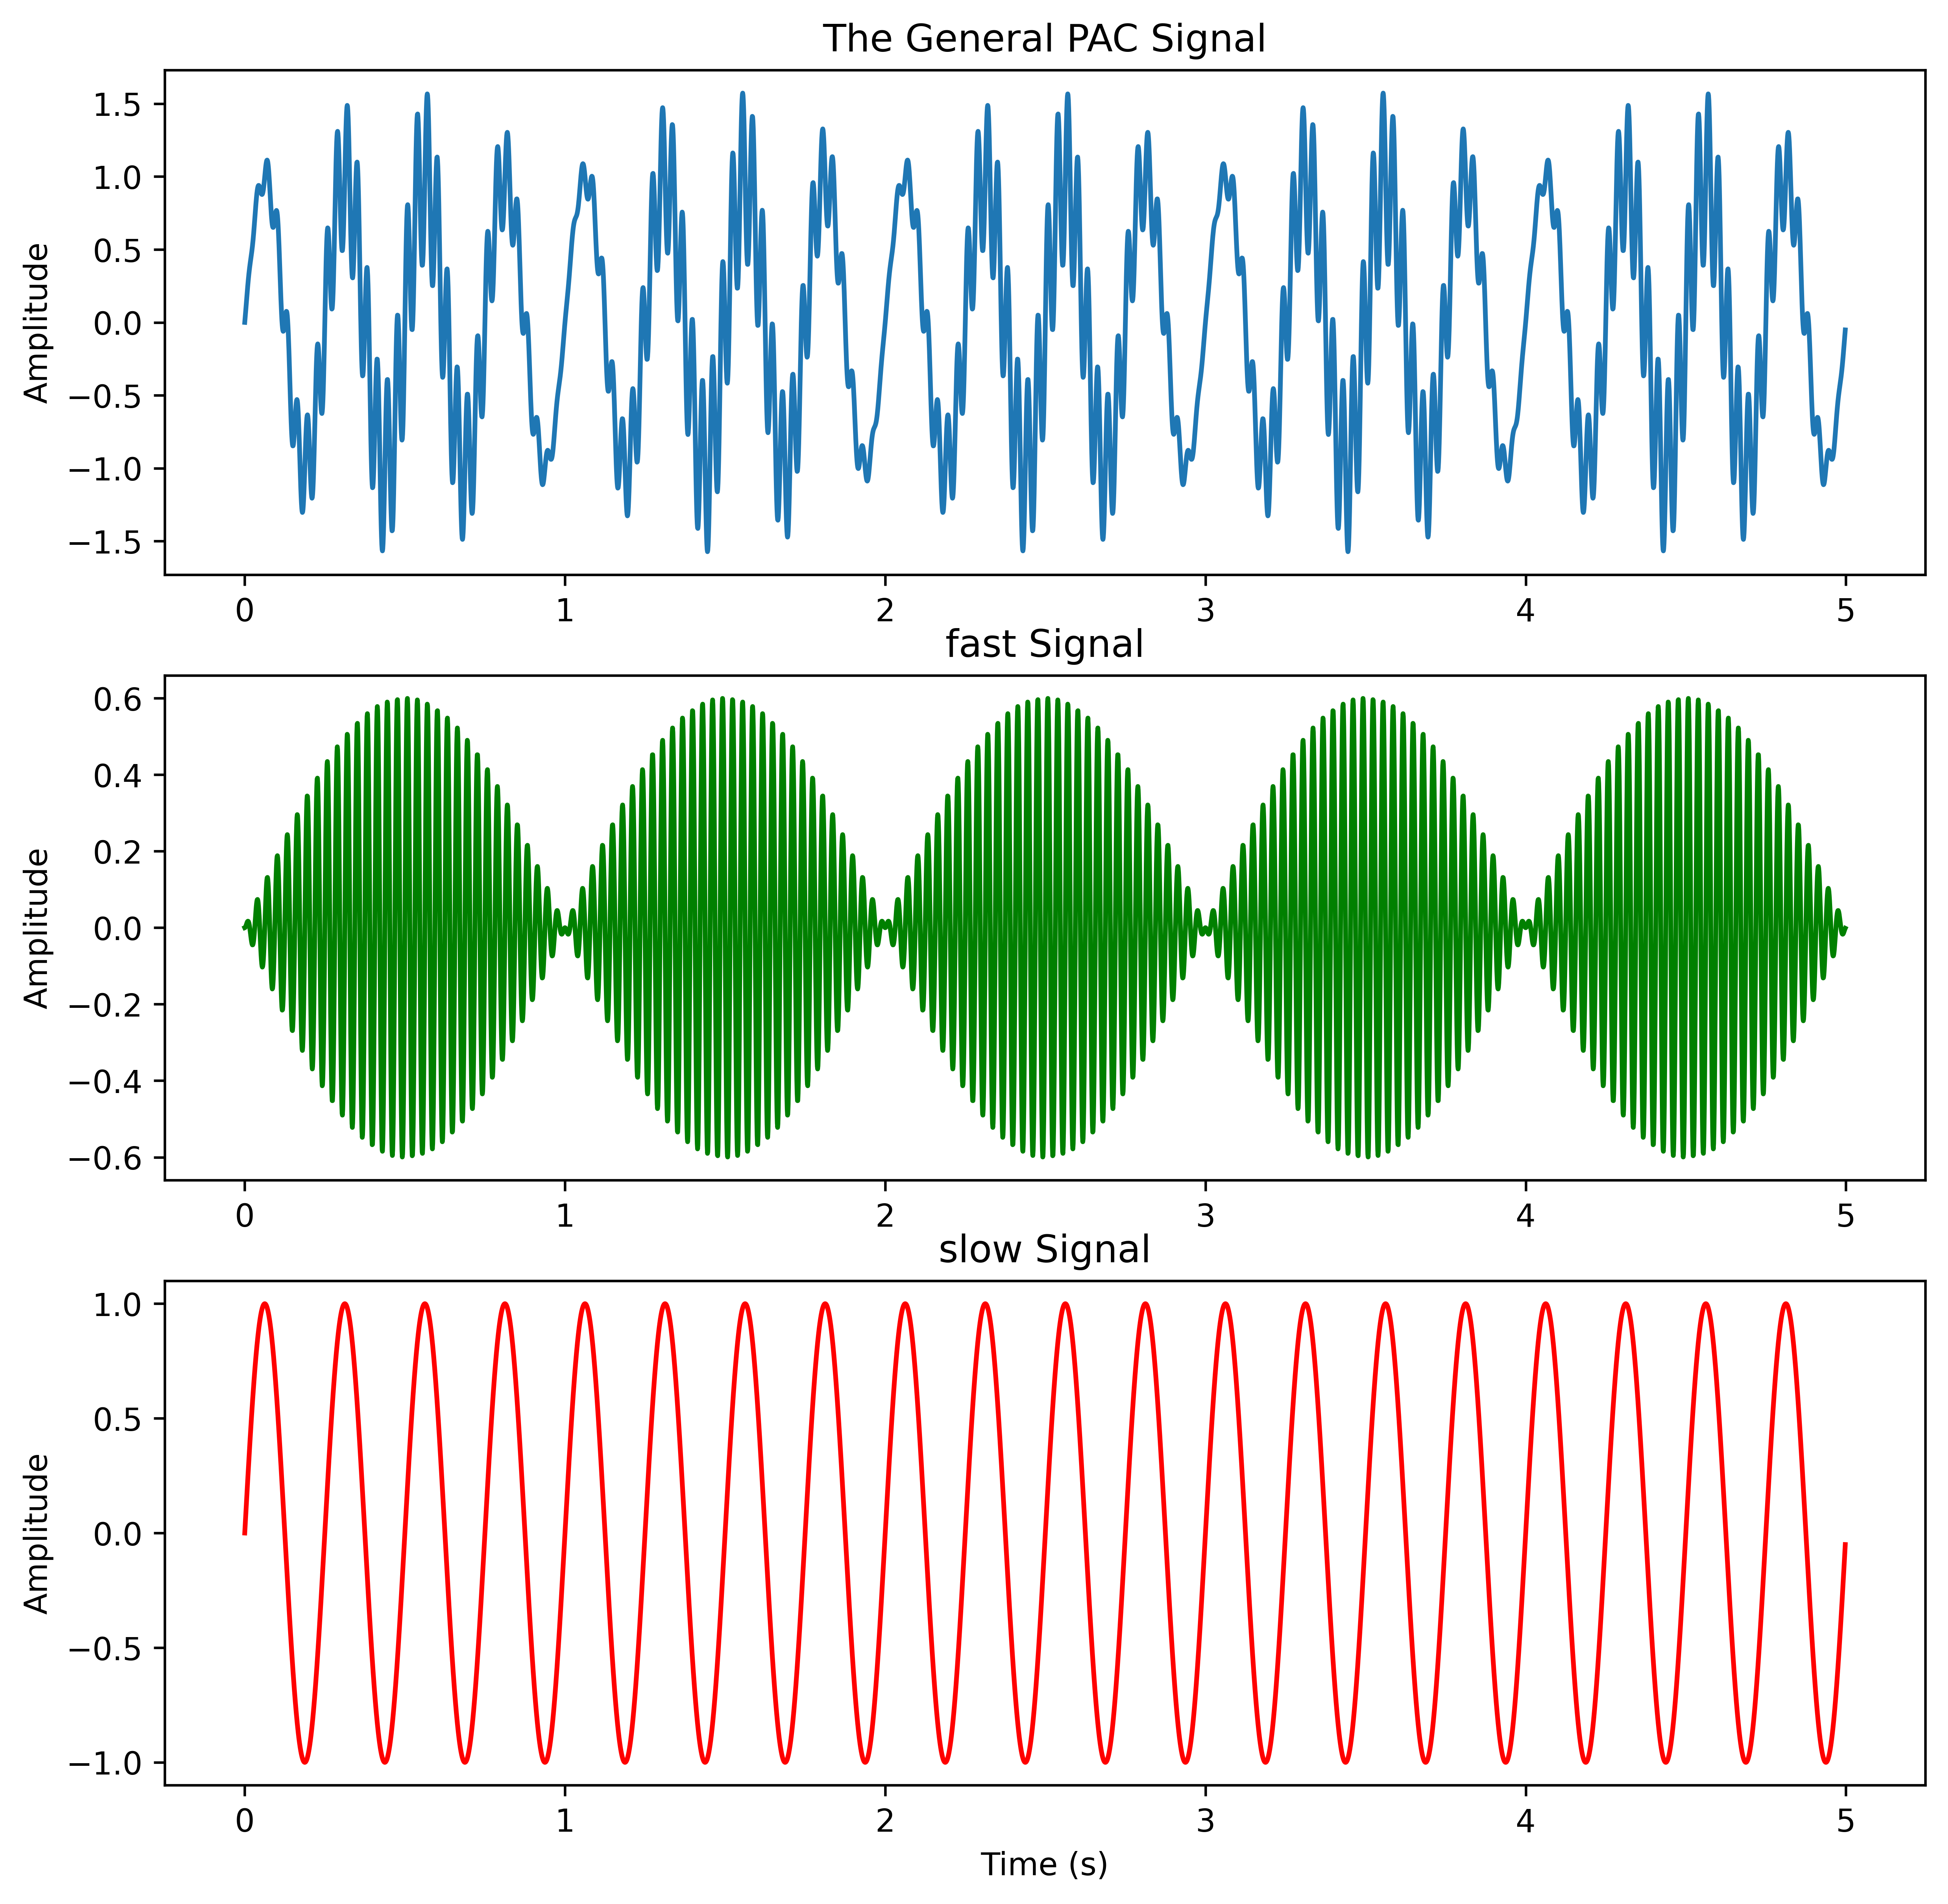

In [49]:
fs = 1000                            # sampling frequency (samples per second/Hz) 
dt = 1/fs                           # seconds per sample 
stopTime = 5                        # length of signal in seconds 
t = np.arange(0, stopTime-dt, dt).T # time vector in seconds 
stopTime_plot = 2                   #limit time axis for improved visualization 

# 生成调制后的信号
f_P = 4       # 低频相位
f_A = 32      # 高频幅度
f_AM = 0.5    # f_AM表示振幅调制的频率
Afp = 1       # AfP是固定的标量，决定SO（慢波）的峰值振幅、
K = 2         # K是固定的标量，决定FO（快波）的峰值振幅、
beta = 0.3

Xf_P = Afp * np.sin(2 * np.pi * f_P * t)       # 慢波（低频相位）
Afa = K * beta * np.sin(2 * np.pi * f_AM * t)  
Xf_A = Afa * np.sin(2 * np.pi * f_A * t)       # 快波（高频振幅）

signal = Xf_A + Xf_P

# 绘制调制信号
plt.figure(figsize=(10, 10), dpi = 600)
plt.subplot(3,1,1)
plt.plot(t, signal)
plt.ylabel('Amplitude')
plt.title('The General PAC Signal')

plt.subplot(3,1,2)
plt.plot(t, Xf_A, 'g')
plt.ylabel('Amplitude')
plt.title('fast Signal')

plt.subplot(3,1,3)
plt.plot(t, Xf_P, 'r')
plt.ylabel('Amplitude')
plt.title('slow Signal')
plt.xlabel('Time (s)')
plt.show()

### 4. 计算耦合值

#### 4.1 获取低频信号相位和高频信号幅值

In [50]:
phasefilt = filterFGx(signal, fs, f_P, 0.5)
phase = np.angle(hilbert(phasefilt))

ampfilt = filterFGx(signal, fs, f_A, 20)
amp = np.abs(hilbert(ampfilt))**2

#### 4.2 CFC

In [52]:
PLV_observed = PLV_CFC_WSH(phase, amp)
MVL_observed = MVL_CFC_WSH(phase, amp)
n_hist_bins = 18
[MI_observed, meanAmp] = MI_CFC_WSH(phase, amp, n_hist_bins)

npnts = len(signal)
n_iter = 1000
PLV_shuffled = np.zeros(n_iter)
MVL_shuffled = np.zeros(n_iter)
MI_shuffled = np.zeros(n_iter)
for ni in range(n_iter):
    cutpoint = random.randrange(np.round(npnts/10), np.round(npnts*.9))
    new_amp = np.concatenate((amp[cutpoint:] , amp[:cutpoint]))

    PLV_shuffled[ni] = PLV_CFC_WSH(phase, new_amp)
    MVL_shuffled[ni] = MVL_CFC_WSH(phase, new_amp)
    [MI, meanAmp] = MI_CFC_WSH(phase, new_amp, n_hist_bins)
    MI_shuffled[ni] = MI
    
PLV_CFCz = (PLV_observed - np.mean(PLV_shuffled))/np.std(PLV_shuffled)
MVL_CFCz = (MVL_observed- np.mean(MVL_shuffled))/np.std(MVL_shuffled)
MI_CFCz = (MI_observed - np.mean(MI_shuffled))/np.std(MI_shuffled)

print('PLV_CFCz: ',PLV_CFCz)
print('MVL_CFCz: ',MVL_CFCz)
print('MI_CFCz: ',MI_CFCz)

PLV_CFCz:  -1.7898737695309208
MVL_CFCz:  3.001918698000109
MI_CFCz:  1.72332066854976


## 二、计算EEG信号耦合值

### 5 加载EEG信号

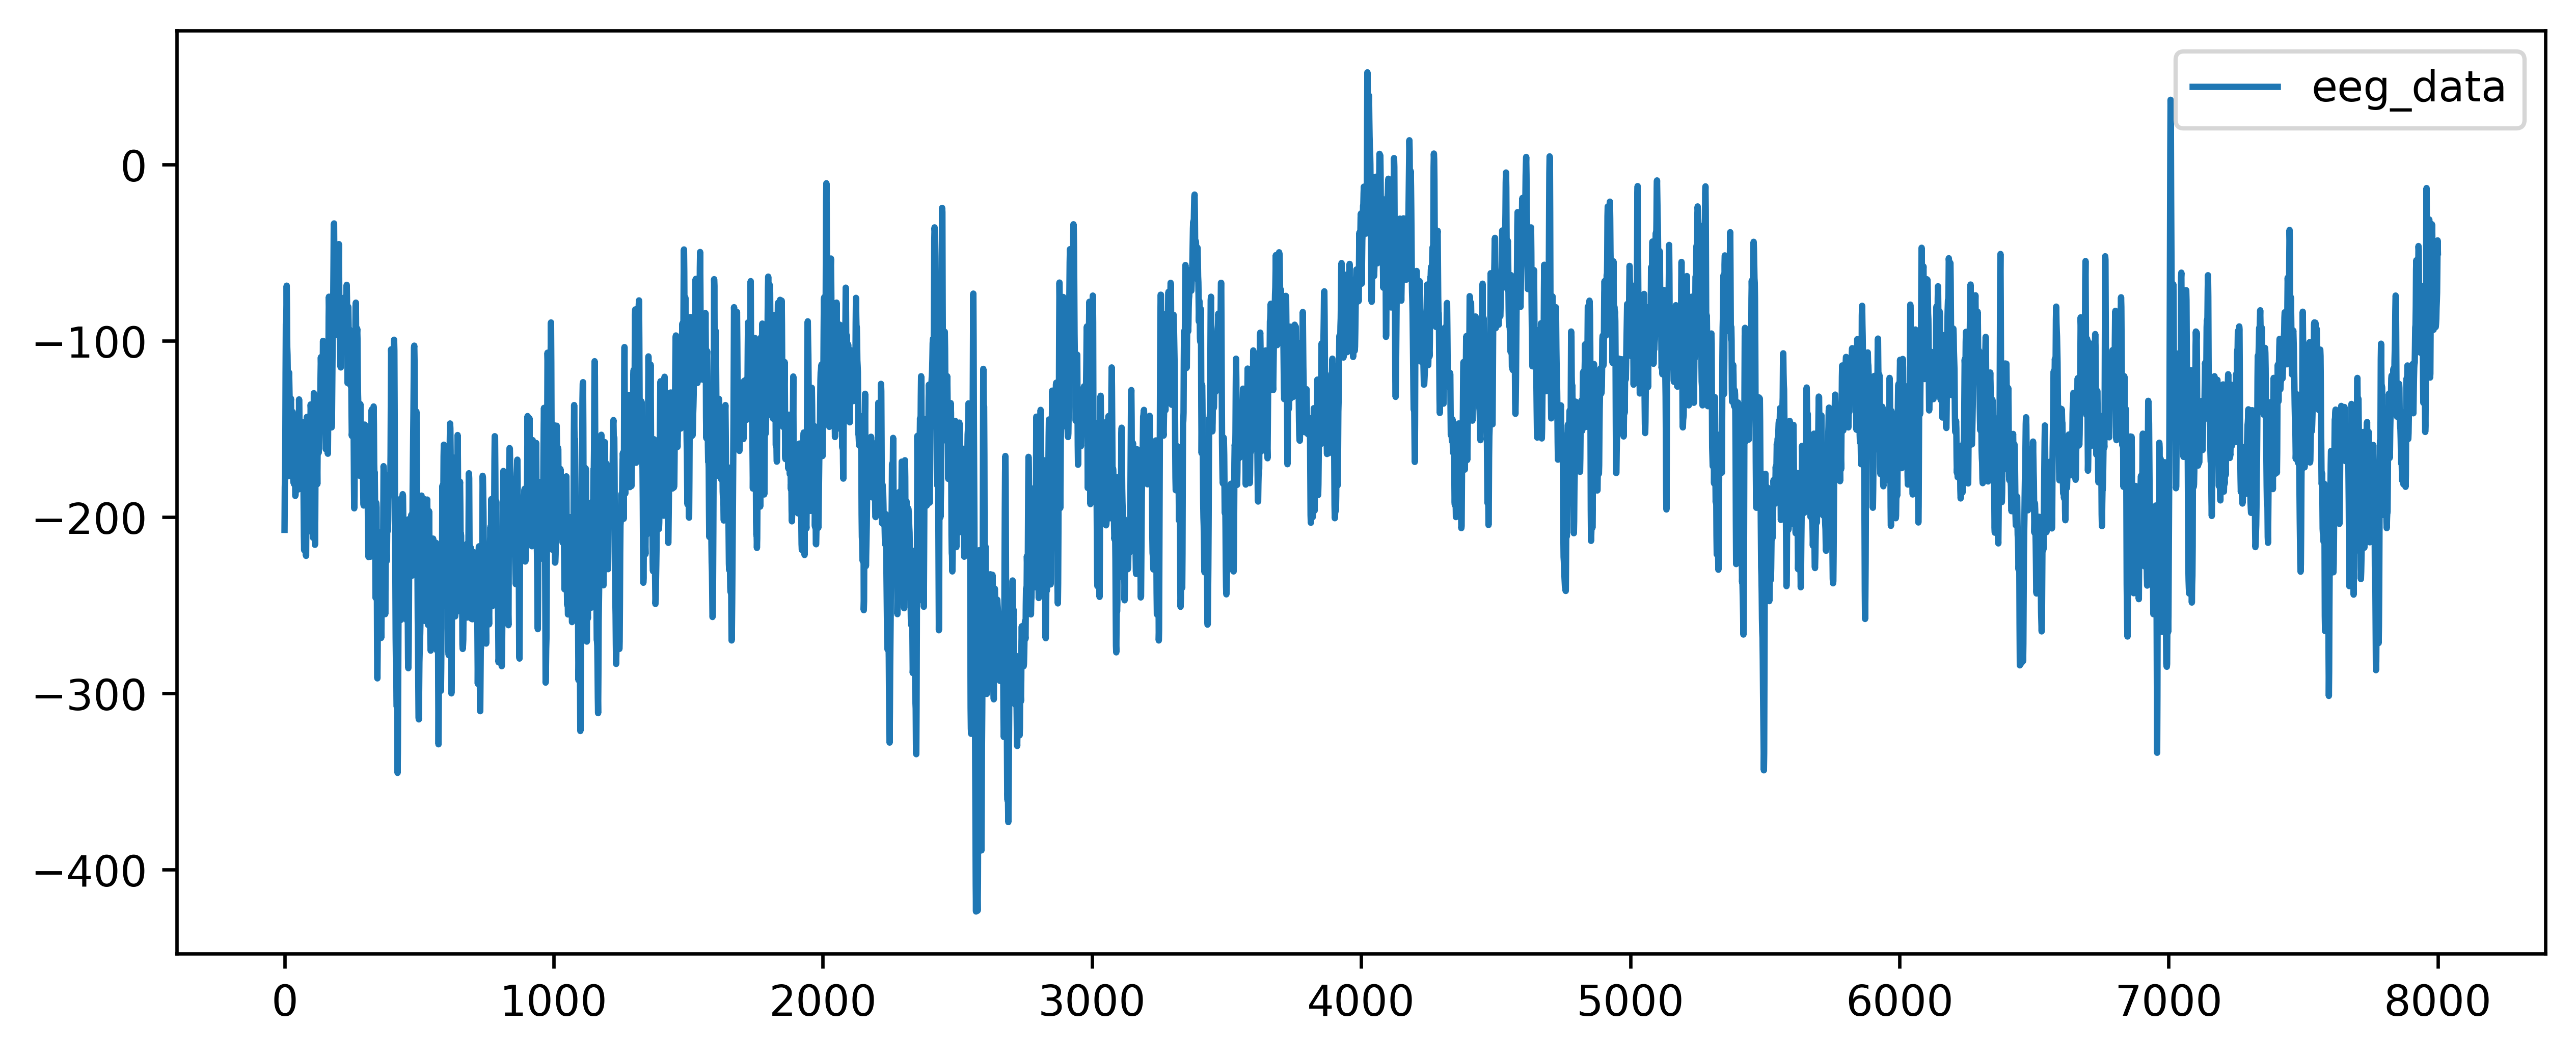

In [53]:
data = scipy.io.loadmat('accumbens_eeg.mat')
srate = 1000
npnts = len(data)
eeg = data['eeg'].reshape(-1)
fig = plt.figure(figsize=(10, 4),dpi=600)
ax1 = fig.add_subplot(1, 1, 1)  # 子图1
ax1.plot(eeg, label='eeg_data')
ax1.legend()
plt.show()

### 6 计算耦合值

In [92]:
# define frequencies for phase and for amplitude
phas_freqs =  np.arange(5, 20, 2)
ampl_freqs = np.arange(30, 150, 5)

# number of iterations used for permutation testing
n_iter = 500

# initialize output phase-amplitude matrix
phaseamp = np.zeros([len(phas_freqs),len(ampl_freqs)])

# loop over frequencies for phase
for lower_fi in range(len(phas_freqs)):
    
    # get phase values
    phasefilt = filterFGx(eeg, srate, phas_freqs[lower_fi], phas_freqs[lower_fi]*.4)
    phase = np.angle(hilbert(phasefilt))
    # phase = angle(hilbert(phasefilt))
    
    for upper_fi in range(len(ampl_freqs)):
        
        # get power values (note: 'power' is a built-in function so we'll name this variable 'amp')
        ampfilt = filterFGx(eeg, srate, ampl_freqs[upper_fi], ampl_freqs[upper_fi]*.78)
        amplit = np.abs(hilbert(ampfilt))**2
        
        # calculate observed modulation index(MVL)
        [modidx, _] = MI_CFC_WSH(phase, amplit, 30)
        
        # now use permutation testing to get Z-value
        bm = np.zeros(n_iter)
        for bi in range (n_iter):
            cutpoint = random.randrange(np.round(npnts/10), np.round(npnts*.9))
            new_amp = np.concatenate((amplit[cutpoint:] , amplit[:cutpoint]))
            [mi, _] = MI_CFC_WSH(phase, new_amp, 30)
            bm[bi] = mi
        # the value we use is the normalized distance away from the mean of
        # boot-strapped values
        phaseamp[lower_fi, upper_fi] = (modidx - np.mean(bm)) / np.std(bm)

### 7 可视化结果

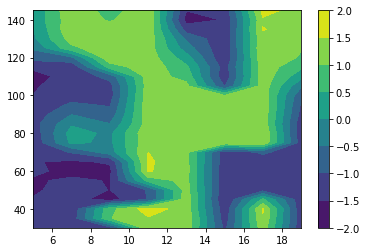

In [96]:
fig, ax = plt.subplots()
CFC_WSH = ax.contourf(phas_freqs, ampl_freqs, phaseamp.T)
cbar = fig.colorbar(CFC_WSH)
plt.show()